In this notebook, lightgbm hyperparameters will be tuned on the final feature dataframe. Final model parameters will be chosen based on the one which gives best ROC AUC metric.
First lightgbm base model will be developed on SMOTE and non SMOTE data. Based on the model performance on these two, final hyperparameters will be tuned on either SMOTE or NON SMOTE data.

## Importing libraries, modules and data

In [ ]:
# Importing the required libraries and modules
import os
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from tqdm import tqdm

!pip install kds
import kds
from IPython.display import Image

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing the train test oot and train_smote dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. X_train dataframe
pickle_in=open(pickle_path+"X_train_final.pickle","rb")
X_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train dataframe is",X_train.shape)

#2. y_train dataframe
pickle_in=open(pickle_path+"y_train_final.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train dataframe is",y_train.shape)

#3. X_train_smote dataframe
pickle_in=open(pickle_path+"X_train_smote_final.pickle","rb")
X_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train_smote dataframe is",X_train_smote.shape)

#4. y_train_smote dataframe
pickle_in=open(pickle_path+"y_train_smote_final.pickle","rb")
y_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train_smote dataframe is",y_train_smote.shape)

#5. X_test dataframe
pickle_in=open(pickle_path+"X_test_final.pickle","rb")
X_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test dataframe is",X_test.shape)

#6. y_test dataframe
pickle_in=open(pickle_path+"y_test_final.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_test dataframe is",y_test.shape)

#7. X_oot dataframe
pickle_in=open(pickle_path+"X_oot_final.pickle","rb")
X_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_oot dataframe is",X_oot.shape)

#8. y_oot dataframe
pickle_in=open(pickle_path+"y_oot_final.pickle","rb")
y_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_oot dataframe is",y_oot.shape)

#9. X_test_oot dataframe
pickle_in=open(pickle_path+"X_test_oot_final.pickle","rb")
X_test_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test_oot dataframe is",X_test_oot.shape)

Shape of X_train dataframe is (246008, 15)
Shape of y_train dataframe is (246008,)
Shape of X_train_smote dataframe is (452272, 15)
Shape of y_train_smote dataframe is (452272,)
Shape of X_test dataframe is (30751, 15)
Shape of y_test dataframe is (30751,)
Shape of X_oot dataframe is (30752, 15)
Shape of y_oot dataframe is (30752,)
Shape of X_test_oot dataframe is (48744, 15)


## Model Functions

In [ ]:
def PlotConfusionMatrix(y_test,pred_test):
  cf=metrics.confusion_matrix(y_test,pred_test)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:0.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
  labels=np.asarray(labels).reshape(2,2)

  fig=plt.figure(figsize=(15,5))
  ax=fig.add_subplot(1,2,1)
  sns.heatmap(cf,cmap='crest',linewidth=0.5,annot=labels,fmt='',ax=ax)
  plt.title('Confusion Matrix')
  plt.ylabel('Real Classes')
  plt.xlabel('Predicted Classes')
  plt.show()

  accuracy = np.trace(cf) / float(np. sum(cf))
  precision = cf[1,1] / sum(cf[:,1])
  recall = cf[1,1]/sum(cf[1,:])
  f1_score = 2*precision*recall / (precision + recall)

  stats_text = "Accuracy={:0.5f}\nPrecision={:0.5f}\nRecall={:0.5f}\nF1 Score={:0.5F}".format(accuracy,precision,recall,f1_score)
  print("----------------Classification Report----------------")
  print(classification_report(y_test,pred_test))
  print("\n",'----------------Accuracy, precision, recall, f1_score----------------')
  print(stats_text)


In [ ]:
def decile_tablel(act,prob,round_decimal=10,change_deciles=10):
  qq=kds.metrics.decile_table(act,prob
                              ,round_decimal=round_decimal
                              ,change_deciles=change_deciles
                              ,labels=False)[['decile',
                                              'prob_min', 'prob_max',
                                              'cnt_cust', 'cnt_resp',
                                              'cnt_non_resp','cum_non_resp',
                                              'cum_resp', 'KS', 'lift']]
  qq["FP"]=round(qq['cnt_non_resp']/qq['cnt_resp'],2)
  qq["FP_cumm"]=round(qq['cum_non_resp']/qq['cnt_resp'],2)
  qq['prob_min']= round(qq['prob_min'], 6)
  qq['frd_cptr%'] = round(qq['cum_resp']/qq.cnt_resp.sum()*100,2)
  qq.columns = ['decile', 'prob_min', 'prob_max', 'ttl_customers', 'bad_customers','gd_customers', 'cum gd_customers',
                'cum_bad_customers', 'KS', 'Lift', 'FP', 'cum FP', 'default_captr%']
  return qq

In [ ]:
def ROC_curve_combined(actl_train,pred_train,actl_test,pred_test,actl_oot,pred_oot):
  print('Ploting the ROC Curve')
  fpr_train, tpr_train, thresholds =metrics.roc_curve(actl_train, pred_train)
  roc_auc_train = metrics.auc(fpr_train, tpr_train)*100 # compute area under the curve

  fpr_test, tpr_test, thresholds =metrics.roc_curve(actl_test, pred_test)
  roc_auc_test = metrics.auc(fpr_test, tpr_test)*100 # compute area under the curve

  fpr_oot, tpr_oot, thresholds =metrics.roc_curve(actl_oot, pred_oot)
  roc_auc_oot = metrics.auc(fpr_oot, tpr_oot)*100 # compute area under the curve

  plt.figure()
  plt.plot(fpr_train, tpr_train, label='Train ROC curve (area=%0.2f%%)' % (roc_auc_train))
  plt.plot(fpr_test, tpr_test, label='Test ROC curve (area=%0.2f%%)' % (roc_auc_test))
  plt.plot(fpr_oot, tpr_oot, label='OOT ROC curve (area=%0.2f%%)' % (roc_auc_oot))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Bate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc= "lower right")
  plt.show()

## LightGbm base model on SMOTE data

In [ ]:
# Lets fit the model
lgbm_clf = LGBMClassifier(random_state=0).fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 226136, number of negative: 226136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.576824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 452272, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# predict the probabilities
lgbm_clf_proba_train_smote=lgbm_clf.predict_proba(X_train_smote)
lgbm_clf_proba_train=lgbm_clf.predict_proba(X_train)
lgbm_clf_proba_test=lgbm_clf.predict_proba(X_test)
lgbm_clf_proba_oot=lgbm_clf.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgbm_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,lgbm_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,lgbm_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,lgbm_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.9661097410981565
Train AUC is  0.7083729021849434
Test AUC is  0.7053139292519439
OOT AUC is  0.6992518044165331


## LightGbm base model on NON SMOTE data

In [ ]:
# Lets fit the model
lgbm_clf = LGBMClassifier(random_state=0).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 19872, number of negative: 226136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080778 -> initscore=-2.431825
[LightGBM] [Info] Start training from score -2.431825


In [ ]:
# predict the probabilities
lgbm_clf_proba_train_smote=lgbm_clf.predict_proba(X_train_smote)
lgbm_clf_proba_train=lgbm_clf.predict_proba(X_train)
lgbm_clf_proba_test=lgbm_clf.predict_proba(X_test)
lgbm_clf_proba_oot=lgbm_clf.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgbm_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,lgbm_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,lgbm_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,lgbm_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7828404974258829
Train AUC is  0.7922508144574065
Test AUC is  0.760015805880053
OOT AUC is  0.7565572913899693


### Observations:
As LightGbm model ROC AUC metric for Non SMOTE data shown a high ROC AUC than SMOTE train data, lets select the hyperparamets based on NON SMOTE data.

## Hyperparameter tuning of Lightgbm model on Non SMOTE data:
Reference= https://www.kaggle.com/code/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
fit_params={
    #"early_stopping":30,
            "eval_metric" : 'auc',
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            # 'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

In [ ]:
opt_parameters = {'colsample_bytree': 0.8014727552433422,
                  'min_child_samples': 213,
                  'min_child_weight': 1,
                  'num_leaves': 10,
                  'reg_alpha': 50,
                  'reg_lambda': 1,
                  'subsample': 0.8415917707455343}

In [ ]:
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
clf_sw = LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.8014727552433422, metric='None',
               min_child_samples=213, min_child_weight=1, n_estimators=5000,
               n_jobs=4, num_leaves=10, random_state=314, reg_alpha=50,
               reg_lambda=1, silent=True, subsample=0.8415917707455343)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
gs_sample_weight = GridSearchCV(estimator=clf_sw,
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [ ]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there ar

### Observations:
1. LighGbm model on train non SMOTE data has shown lesser bias and variance as compared to SMOTE data.
2. Following hyperparameters selected for logistic regression:

a. colsample_bytree : 0.8014727552433422,

b. min_child_samples : 213,

c. min_child_weight : 1,

d. num_leaves: 10,

e. reg_alpha: 50,

f. reg_lambda : 1,

g. subsample: 0.8415917707455343

h. scale_pos_weight: 2

These values are selected based on the bias variance tradeoff.

## LightGbm final model:
Lets asses the performance of the LightGbm hyperparameter tuned model.


In [ ]:
opt_parameters = {'colsample_bytree': 0.8014727552433422,
                  'min_child_samples': 213,
                  'min_child_weight': 1,
                  'num_leaves': 10,
                  'reg_alpha': 50,
                  'reg_lambda': 1,
                  'subsample': 0.8415917707455343,
                  'scale_pos_weight':2}

In [ ]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 19872, number of negative: 226136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 15
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080778 -> initscore=-2.431825
[LightGBM] [Info] Start training from score -2.431825


LGBMClassifier(colsample_bytree=0.8014727552433422, metric='None',
               min_child_samples=213, min_child_weight=1, n_estimators=5000,
               n_jobs=4, num_leaves=10, random_state=314, reg_alpha=50,
               reg_lambda=1, scale_pos_weight=2, silent=True,
               subsample=0.8415917707455343)

In [ ]:
# predict the target classes and probabilities
lgbm_clf_predict_train_smote=clf_final.predict(X_train_smote)
lgbm_clf_predict_train=clf_final.predict(X_train)
lgbm_clf_predict_test=clf_final.predict(X_test)
lgbm_clf_predict_oot=clf_final.predict(X_oot)

lgbm_clf_proba_train_smote=clf_final.predict_proba(X_train_smote)
lgbm_clf_proba_train=clf_final.predict_proba(X_train)
lgbm_clf_proba_test=clf_final.predict_proba(X_test)
lgbm_clf_proba_oot=clf_final.predict_proba(X_oot)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent


In [ ]:
# As the ROC AUC matches with previously obtained value lets pickle the model
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+'lgbm_clf.pickle', 'wb')
pickle.dump(clf_final,pickle_out)
pickle_out.close()

### ROC AUC

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,lgbm_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,lgbm_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,lgbm_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,lgbm_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.774023628830517
Train AUC is  0.7705763709565253
Test AUC is  0.7607027140825134
OOT AUC is  0.7597448162636088


Ploting the ROC Curve


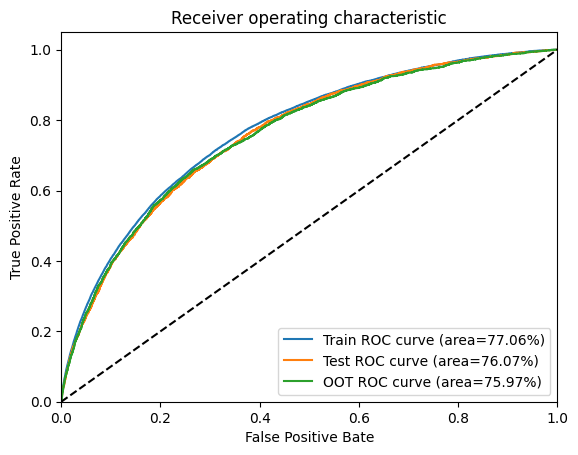

In [ ]:
ROC_curve_combined(y_train,lgbm_clf_proba_train[:,1],y_test,lgbm_clf_proba_test[:,1],y_oot,lgbm_clf_proba_oot[:,1])

### Confusion Matrix

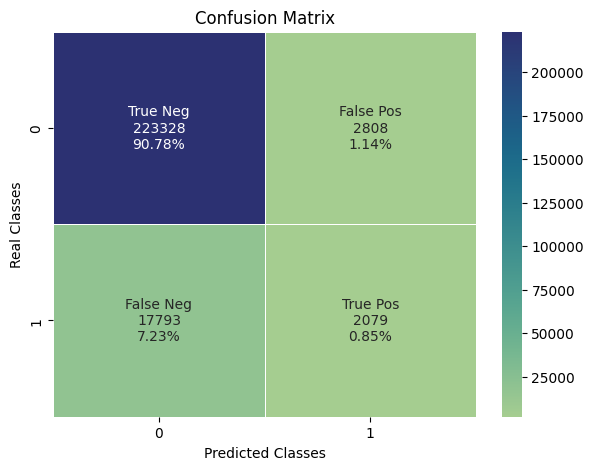

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    226136
           1       0.43      0.10      0.17     19872

    accuracy                           0.92    246008
   macro avg       0.68      0.55      0.56    246008
weighted avg       0.89      0.92      0.89    246008


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91626
Precision=0.42541
Recall=0.10462
F1 Score=0.16794


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_train,lgbm_clf_predict_train)

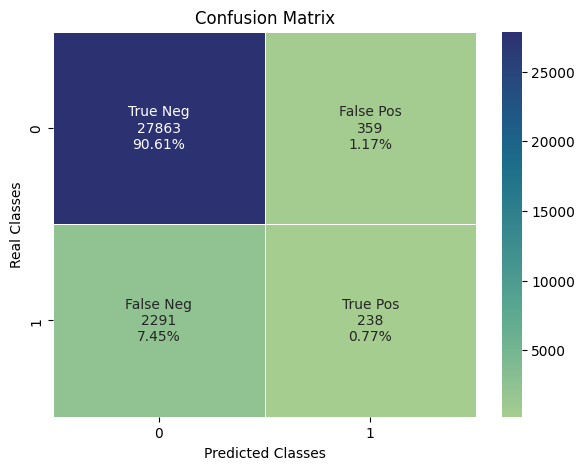

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     28222
           1       0.40      0.09      0.15      2529

    accuracy                           0.91     30751
   macro avg       0.66      0.54      0.55     30751
weighted avg       0.88      0.91      0.89     30751


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91382
Precision=0.39866
Recall=0.09411
F1 Score=0.15227


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_test,lgbm_clf_predict_test)

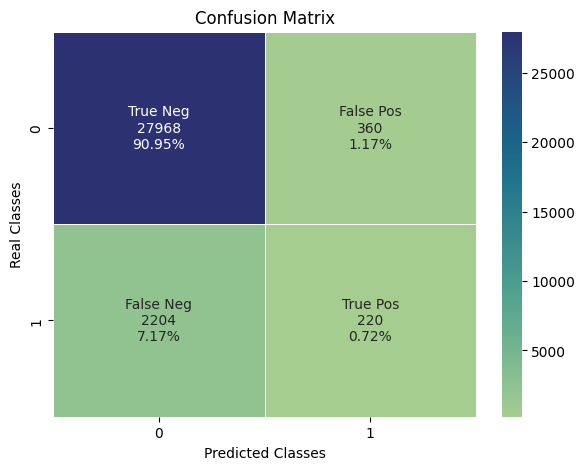

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     28328
           1       0.38      0.09      0.15      2424

    accuracy                           0.92     30752
   macro avg       0.65      0.54      0.55     30752
weighted avg       0.88      0.92      0.89     30752


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91662
Precision=0.37931
Recall=0.09076
F1 Score=0.14647


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_oot,lgbm_clf_predict_oot)

### Decile Table

In [ ]:
decile_tablel(y_train,lgbm_clf_proba_train[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.309672,0.842797,24601.0,6990.0,17611.0,17611.0,6990.0,27.387329,3.517483,2.52,2.52,35.18
1,2,0.213087,0.309670,24601.0,3713.0,20888.0,38499.0,10703.0,36.834991,2.692963,5.63,10.37,53.86
2,3,0.159607,0.213083,24601.0,2557.0,22044.0,60543.0,13260.0,39.954226,2.224217,8.62,23.68,66.73
3,4,0.123783,0.159606,24601.0,1985.0,22616.0,83159.0,15245.0,39.942094,1.917884,11.39,41.89,76.72
4,5,0.098440,0.123782,24600.0,1381.0,23219.0,106378.0,16626.0,36.623856,1.673309,16.81,77.03,83.67
5,6,0.078788,0.098438,24601.0,1098.0,23503.0,129881.0,17724.0,31.755915,1.486512,21.41,118.29,89.19
6,7,0.062996,0.078788,24601.0,832.0,23769.0,153650.0,18556.0,25.431779,1.333963,28.57,184.68,93.38
7,8,0.049555,0.062995,24601.0,617.0,23984.0,177634.0,19173.0,17.930643,1.206027,38.87,287.90,96.48
8,9,0.036810,0.049555,24601.0,451.0,24150.0,201784.0,19624.0,9.520754,1.097241,53.55,447.41,98.75
9,10,0.011707,0.036808,24600.0,248.0,24352.0,226136.0,19872.0,0.000000,1.000000,98.19,911.84,100.00


In [ ]:
decile_tablel(y_test,lgbm_clf_proba_test[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.312607,0.800693,3076.0,835.0,2241.0,2241.0,835.0,25.076389,3.300734,2.68,2.68,33.02
1,2,0.215953,0.312576,3075.0,479.0,2596.0,4837.0,1314.0,34.818184,2.597527,5.42,10.10,51.96
2,3,0.160492,0.215916,3075.0,335.0,2740.0,7577.0,1649.0,38.355789,2.173290,8.18,22.62,65.20
3,4,0.125138,0.160491,3075.0,257.0,2818.0,10395.0,1906.0,38.532790,1.884052,10.96,40.45,75.37
4,5,0.099150,0.125134,3075.0,192.0,2883.0,13278.0,2098.0,35.909289,1.659100,15.02,69.16,82.96
5,6,0.079000,0.099145,3075.0,144.0,2931.0,16209.0,2242.0,31.217724,1.477495,20.35,112.56,88.65
6,7,0.062768,0.078999,3075.0,113.0,2962.0,19171.0,2355.0,25.190535,1.330264,26.21,169.65,93.12
7,8,0.049296,0.062762,3075.0,83.0,2992.0,22163.0,2438.0,17.870807,1.205012,36.05,267.02,96.40
8,9,0.036788,0.049284,3075.0,53.0,3022.0,25185.0,2491.0,9.258538,1.094412,57.02,475.19,98.50
9,10,0.010345,0.036786,3075.0,38.0,3037.0,28222.0,2529.0,0.000000,1.000000,79.92,742.68,100.00


In [ ]:
decile_tablel(y_oot,lgbm_clf_proba_oot[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.307906,0.793842,3076.0,818.0,2258.0,2258.0,818.0,25.774962,3.373710,2.76,2.76,33.75
1,2,0.213366,0.307898,3075.0,456.0,2619.0,4877.0,1274.0,35.341574,2.627631,5.74,10.70,52.56
2,3,0.159880,0.213288,3075.0,327.0,2748.0,7625.0,1601.0,39.131023,2.201500,8.40,23.32,66.05
3,4,0.124578,0.159847,3075.0,205.0,2870.0,10495.0,1806.0,37.456800,1.862593,14.00,51.20,74.50
4,5,0.098471,0.124576,3075.0,198.0,2877.0,13372.0,2004.0,35.469088,1.653465,14.53,67.54,82.67
5,6,0.078945,0.098456,3076.0,141.0,2935.0,16307.0,2145.0,30.925146,1.474771,20.82,115.65,88.49
6,7,0.063071,0.078944,3075.0,104.0,2971.0,19278.0,2249.0,24.727718,1.325399,28.57,185.37,92.78
7,8,0.049262,0.063068,3075.0,80.0,2995.0,22273.0,2329.0,17.455470,1.200991,37.44,278.41,96.08
8,9,0.036530,0.049259,3075.0,58.0,3017.0,25290.0,2387.0,9.197969,1.094143,52.02,436.03,98.47
9,10,0.012510,0.036528,3075.0,37.0,3038.0,28328.0,2424.0,0.000000,1.000000,82.11,765.62,100.00


### Observations and Conclusion:
1. ROC AUC of 75.97% is achieved on the OOT data.
2. At 20% of the total transactions this model was able to capture around 52.56% of total defaulters.

## Predictions on the Kaggle Test dataset:

In [ ]:
# Merged Application test dataframe
pickle_in=open(pickle_path+"application_test_merged.pickle","rb")
application_test_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test merged dataframe is",application_test_merged.shape)

Shape of featurized Application test merged dataframe is (48744, 1771)


In [ ]:
# Prediction on the application_test_merged dataframe
lgbm_clf_proba_test_oot=clf_final.predict_proba(X_test_oot)

[LightGBM] [Warning] Unknown parameter: silent


In [ ]:
# Preparing the dataframe to be submitted at Kaggle Submission
LGBM_sol_kaggle=pd.DataFrame(application_test_merged['SK_ID_CURR'])
LGBM_sol_kaggle['TARGET'] = pd.Series(lgbm_clf_proba_test_oot[:,1])
LGBM_sol_kaggle

,SK_ID_CURR,TARGET
0,100001,0.115334
1,100005,0.154587
2,100013,0.081503
3,100028,0.062975
4,100038,0.278119
...,...,...
48739,456221,0.060187
48740,456222,0.162239
48741,456223,0.062783
48742,456224,0.092417


In [ ]:
# Lets save a dataframe as csv and upload the results on the kaggle submission
LGBM_sol_kaggle.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/LGBM_sol_kaggle.csv',index=False)

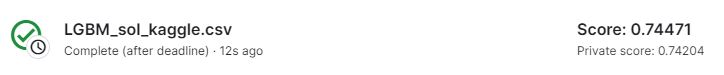

In [ ]:
Image(filename='/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/LightGBMKaggleResult.JPG',width=800,height=100)

### Observations about the kaggle solution submission:
ROC AUC of 74.47% is achieved on the kaggle test data for this model.